In [1]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
import torch
print(torch.__version__)

0.3.1


In [2]:
# 31072 * 4 + 298424

# 422712

# 469520

# 117380 * 4

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
from tqdm import tqdm_notebook, tqdm

In [4]:
PATH = './'
TRAIN = '../data/train_combined_all/'
TEST = '../data/test/'
LABELS = '../data/train_combined_all2.csv'
SAMPLE = '../data/sample_submission.csv'

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [6]:
nw = 2   #number of workers for data loader
arch = resnet50 #specify target architecture

In [7]:
# train_names_png = list({f[:36] for f in os.listdir(TRAIN) if 'png' in f})
# train_names_jpg = []
# for f in tqdm_notebook(os.listdir(TRAIN)):
#     if 'png' in f:
#         continue
#     name = f.split('.')[0]
#     name = name.split('_')
#     if len(name) == 5:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]
#     else:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+name[4]
#     if name not in train_names_jpg:
#         train_names_jpg.append(name)

# train_names = train_names_png + train_names_jpg
# test_names = list({f[:36] for f in os.listdir(TEST)})


# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [8]:
import pickle
with open('../cache/train_names', 'rb') as f:
    train_names = pickle.load(f)
print(len(train_names))
test_names = list({f[:36] for f in os.listdir(TEST)})
train_names = train_names + test_names
print(len(train_names))
tr_n, val_n = train_test_split(train_names, test_size=0.01, random_state=42)

105678
117380


In [9]:
# import pickle
# with open('../cache/train_names', 'wb') as f:
#     pickle.dump(train_names, f)
# with open('../cache/train_names_png1', 'wb') as f:
#     pickle.dump(train_names_png, f)
# with open('../cache/train_names_png2', 'wb') as f:
#     pickle.dump(train_names_jpg, f)

In [10]:
# len(train_names), len(train_names_jpg), len(train_names_png)
# (105678, 74606, 31072)

In [11]:
def open_rgby(path,id): #a function that reads RGBY image
#     colors = ['red','green','blue','yellow']
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [12]:
# ??FilesDataset

In [13]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
#         print(fnames)
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [14]:
# ??tfms_from_stats
path_to_train = '../data/train_combined_all'
data = pd.read_csv('../data/train_combined_all2.csv')

In [15]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
#     stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
#     stats = A([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])
#     stats = A([0.0751 , 0.05909, 0.04364], [0.11428, 0.09856, 0.09925])
    stats = A([0.07426, 0.05844, 0.04441], [0.11508, 0.09855, 0.10259])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [16]:
# bs = 16
# sz = 512
# md = get_data(sz,bs)

In [17]:
# x_tot = np.zeros(3)
# x2_tot = np.zeros(3)
# for x,y in tqdm_notebook(iter(md.trn_dl)):
#     x = md.trn_ds.denorm(x).reshape(-1,3)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std
# (array([0.0751 , 0.05909, 0.04364]), array([0.11428, 0.09856, 0.09925])) # for data plus ext_data
# (array([0.07426, 0.05844, 0.04441]), array([0.11508, 0.09855, 0.10259])) # train + ext_data + test

In [18]:
# mean = 0
# x2_tot = 0
# count = 0
# M2 = 0
# for name, labels in tqdm(zip(data['Id'], data['Target'].str.split(' '))):
#     if name not in tr_n:
#         continue
#     file = os.path.join(path_to_train, name)
#     image = load_image(file, (512, 512))/255.
#     val = np.reshape(image[:,:,0], -1)
#     img_mean = np.mean(val)
#     img_std = np.std(val)
#     count = count + 1
#     mean = mean + img_mean
#     M2 = M2 + img_std
#     x2_tot += np.mean(val**2)
# print('red mean', mean/(count))
# print('red std', M2/(count))
# channel_std = np.sqrt(x2_tot/count - ((mean/count)**2))

# 31072it [05:35, 92.74it/s]
# red mean 0.08052112660092407
# red std 0.13001299317356493

In [19]:
# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
# #     print(x.shape)
# #     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
# #     print(x.shape)
# #     x = x.cpu().numpy().reshape(-1,4)
# #     print(x.shape)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

# (array([0.08702, 0.06006, 0.06512, 0.08925]),
#  array([0.14109, 0.1055 , 0.15163, 0.14201]))

In [20]:
# ??md.trn_ds.denorm

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [22]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [23]:
sz = 512 #image size
bs = 16  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

 65%|██████▌   | 4321/6602 [48:50<39:03,  1.03s/it, loss=4.83]  

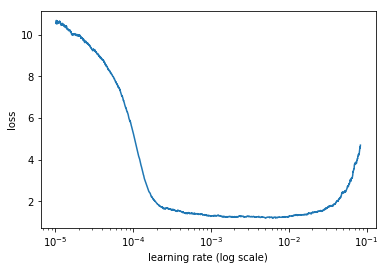

In [24]:
learner.lr_find()
learner.sched.plot()

In [24]:
lr = 8e-4
learner.fit(lr,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                            
    0      1.081009   1.046351   0.955068  



[array([1.04635]), 0.9550681424912643]

In [25]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [26]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.755111   0.700008   0.969579  
    1      0.691261   0.655222   0.971222                        
    2      0.694762   0.655564   0.971252                        
    3      0.651587   0.630344   0.972226                        
    4      0.660772   0.642621   0.971313                          
    5      0.625914   0.595909   0.973473                        
    6      0.672179   0.603632   0.972591                        
    7      0.625442   0.589698   0.973108                        



[array([0.5897]), 0.9731078125549134]

In [27]:
learner.save('ResNet50_512_55Max_1')

In [28]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.686651   0.61454    0.972469  
    1      0.632972   0.600716   0.972864                        
    2      0.587142   0.585826   0.973686                        
    3      0.615188   0.571747   0.974112                        
    4      0.650819   0.609595   0.972378                        
    5      0.608153   0.585099   0.974051                        
    6      0.615562   0.579247   0.97399                         
    7      0.56599    0.554852   0.974994                        



[array([0.55485]), 0.9749939163458206]

In [29]:
learner.save('ResNet50_512_55Max_2')

In [30]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.553513   0.560411   0.975146  
    1      0.541489   0.558586   0.974325                        
    2      0.538525   0.55796    0.974872                        
    3      0.544691   0.557769   0.974963                          
    4      0.531812   0.553045   0.975055                          
    5      0.507357   0.553215   0.975176                        
    6      0.510817   0.546977   0.97542                         
    7      0.522604   0.543653   0.975602                        



[array([0.54365]), 0.9756023386268031]

In [31]:
learner.save('ResNet50_512_55Max')

In [32]:
# ??learner.TTA

In [33]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [34]:
preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [35]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [36]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.54303 0.60296 0.56924 0.42761 0.46502 0.45829 0.49615 0.54881 0.49584 0.59834 0.54025 0.56244 0.4653
 0.46866 0.55344 0.53668 0.64387 0.5604  0.44206 0.56443 0.68629 0.54093 0.54559 0.50831 0.67425 0.51744
 0.46602 0.44089]
F1 macro:  0.7412795979033403
F1 macro (th = 0.5):  0.7041589687497953
F1 micro:  0.7767734867159682


/home/watts/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [37]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [38]:
np.save('../cache/preds_t_55_max', preds_t)

In [39]:
def save_pred(pred, th=0.5, fname='../submissions/sub55-max.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [40]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.46992 0.0517  0.09588 0.06913 0.07657 0.11613 0.06913 0.10682 0.00077 0.00111 0.00145 0.05862 0.03999
 0.02205 0.04991 0.00009 0.07272 0.0505  0.04341 0.08187 0.01333 0.16895 0.03504 0.12468 0.01589 0.34874
 0.03905 0.04025]


In [41]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [42]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [43]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.67575 0.53154 0.67217 0.39843 0.3396  0.51849 0.41997 0.59604 0.14096 0.1465  0.14296 0.5765  0.30004
 0.60559 0.63028 0.14678 0.72331 0.89204 0.56793 0.49416 0.47036 0.60417 0.42837 0.65912 0.71892 0.66077
 0.39911 0.17508]
Fractions:  [0.36669 0.04367 0.0746  0.05914 0.07358 0.0752  0.04153 0.07512 0.0059  0.00709 0.00658 0.04392 0.0423
 0.01427 0.04435 0.00624 0.02897 0.01453 0.02854 0.05931 0.01    0.12665 0.02837 0.07554 0.01    0.22278
 0.02829 0.00658]
Fractions (th = 0.5):  [0.51487 0.04504 0.10605 0.04666 0.04692 0.07862 0.03162 0.09451 0.00068 0.00077 0.00077 0.04939 0.02282
 0.01641 0.04965 0.00009 0.05281 0.0441  0.03734 0.05802 0.00897 0.17185 0.02427 0.1163  0.01316 0.39139
 0.02017 0.00043]


In [44]:
save_pred(pred_t,th_t,'../submissions/sub55-max-f.csv')

In [45]:
save_pred(pred_t,th,'../submissions/sub55-max-v.csv')
save_pred(pred_t,0.5,'../submissions/sub55-max-05.csv')

In [46]:
# save_pred(pred_t,0.5,'../submissions/sub50-max-05.csv')
save_pred(pred_t,0.45,'../submissions/sub55-max-045.csv')
save_pred(pred_t,0.40,'../submissions/sub55-max-040.csv')
save_pred(pred_t,0.35,'../submissions/sub55-max-035.csv')
save_pred(pred_t,0.30,'../submissions/sub55-max-030.csv')
save_pred(pred_t,0.25,'../submissions/sub55-max-025.csv')

In [47]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'../submissions/sub55-max-c.csv')

In [48]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([46764.,  3555., 11944.,  3855.,  5638.,  6784.,  4056., 10466.,   225.,   206.,   189.,  2694.,
         2480.,  1642.,  3233.,    67.,  1727.,   861.,  2285.,  4254.,   530., 15668.,  3010., 11609.,
          566., 41440.,   893.,   134.]),
 array([0.3984 , 0.03029, 0.10175, 0.03284, 0.04803, 0.0578 , 0.03455, 0.08916, 0.00192, 0.00175, 0.00161,
        0.02295, 0.02113, 0.01399, 0.02754, 0.00057, 0.01471, 0.00734, 0.01947, 0.03624, 0.00452, 0.13348,
        0.02564, 0.0989 , 0.00482, 0.35304, 0.00761, 0.00114]))

In [49]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'../submissions/sub55-max-t.csv')

Thresholds:  [0.64352 0.76453 0.52338 0.64807 0.49059 0.60363 0.47776 0.5262  0.23789 0.33225 0.32724 0.84386 0.56136
 0.61566 0.7992  0.32063 0.85518 0.94767 0.64526 0.6269  0.7009  0.58721 0.46969 0.57094 0.89574 0.53948
 0.74463 0.35426]
Fractions:  [0.40138 0.03042 0.10118 0.03299 0.04777 0.05802 0.0335  0.0887  0.00171 0.00171 0.00154 0.02359 0.02102
 0.01384 0.02803 0.00051 0.01453 0.00769 0.01957 0.03623 0.00453 0.13365 0.02521 0.09921 0.00504 0.35464
 0.00769 0.00111]


In [50]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-05.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 482k/482k [00:13<00:00, 37.3kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None          
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None          
sub50_22.csv            2018-12-16 02:16:49               complete  0.059        None          
sub50_22.csv            2018-12-16 02:00:57               complete  0.059        None          
sub50-max-05-notta.csv  2018-12-15 08:41:36               complete  0.020        None          
sub50-max-05-notta.csv  2018-12-15 08:22:48               complete  0.020        None

In [51]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub55-max-05.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target

In [52]:
sub50.to_csv('../submissions/sub55-max-05-l.csv', index=False)

In [58]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-05-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

 17%|██████▍                                | 80.0k/482k [00:01<00:07, 52.7kB/s]^C


KeyboardInterrupt: 

In [54]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-05.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 482k/482k [00:13<00:00, 36.9kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None          
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None          
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None          
sub50_22.csv            2018-12-16 02:16:49               complete  0.059        None          
sub50_22.csv            2018-12-16 02:00:57               complete  0.059        None          
sub50-max-05-notta.csv  2018-12-15 08:41:36               complete  0.020        None

In [55]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-045.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 489k/489k [00:18<00:00, 27.4kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None          
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None          
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None          
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None          
sub50_22.csv            2018-12-16 02:16:49               complete  0.059        None          
sub50_22.csv            2018-12-16 02:00:57               complete  0.059        None

In [56]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub55-max-05.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target
sub50.to_csv('../submissions/sub55-max-05-l.csv', index=False)

In [57]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-05-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 482k/482k [00:08<00:00, 45.6kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None          
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None          
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None          
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None          
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None          
sub50_22.csv            2018-12-16 02:16:49               complete  0.059        None

In [60]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub55-max-045.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target
sub50.to_csv('../submissions/sub55-max-045-l.csv', index=False)

In [61]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-045-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 488k/488k [00:13<00:00, 37.3kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub55-max-045-l.csv     2018-12-17 20:34:48               complete  0.574        None          
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None          
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None          
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None          
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None          
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None

In [ ]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub55-max-040.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

In [75]:
def save_pred(pred, th=0.5, fname='../submissions/sub50-max-notta.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [76]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

ValueError: operands could not be broadcast together with shapes (11702,) (28,) 

In [60]:
# pred= preds_t
# fname='../submissions/sub50-max-notta.csv'
# th=0.5
# pred_list = []
# for line in pred:
#     s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
#     pred_list.append(s)
# sample_df = pd.read_csv(SAMPLE)
# sample_list = list(sample_df.Id)
# pred_dic = dict((key, value) for (key, value) 
#             in zip(learner.data.test_ds.fnames,pred_list))
# pred_list_cor = [pred_dic[id] for id in sample_list]
# df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
# df.to_csv(fname, header=True, index=False)

In [61]:
df.shape

(11702, 2)

In [62]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23


In [80]:
save_pred(pred_t,0.5,'../submissions/sub50-max-05-notta.csv')

In [84]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-05-notta.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-05-notta.csv  2018-12-15 08:41:36               complete  0.020        None          
sub50-max-05-notta.csv  2018-12-15 08:22:48               complete  0.020        None          
sub54-max-a.csv         2018-12-15 06:06:02               complete  0.365        None          
sub50-max-05-l.csv      2018-12-15 05:44:54               complete  0.578        None          
sub50-max-045.csv       2018-12-15 05:36:27               complete  0.528        None          
sub50-max-05.csv        2018-12-14 04:56:42               complete  0.533        None          
sub50-max-c-l.csv       2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv         2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv       2018-12-14 04:48

In [30]:
sub50_050 = pd.read_csv('../submissions/sub50-max-05-l.csv')
sub50_045 = pd.read_csv('../submissions/sub41-t-l.csv')

In [31]:
null_id = sub50_050.Id[sub50_050.Predicted.isnull() == True]

In [32]:
len(null_id)

113

In [33]:
sub50_045_113 = sub50_045.loc[sub50_045.Id.isin(null_id)]

In [34]:
sub50_050_notnull = sub50_050.loc[~sub50_050.Id.isin(null_id)]

In [35]:
sub50_050_notnull.shape

(11589, 2)

In [36]:
sub50_045_113.shape

(113, 2)

In [37]:
sub50_045_113.head()

,Id,Predicted
21,00763d66-bacd-11e8-b2b8-ac1f6b6435d0,NaN
198,03f4b0e8-bad3-11e8-b2b8-ac1f6b6435d0,23
283,06001d6c-bada-11e8-b2b9-ac1f6b6435d0,7
417,090c44f8-bad1-11e8-b2b8-ac1f6b6435d0,NaN
864,12cd54b4-bacc-11e8-b2b8-ac1f6b6435d0,3


In [38]:
sub50_050_notnull_sub50_045_113 = sub50_050_notnull.append(sub50_045_113)

In [39]:
sub50_050_notnull_sub50_045_113.shape

(11702, 2)

In [40]:
null_id2 = sub50_050_notnull_sub50_045_113.Id[sub50_050_notnull_sub50_045_113.Predicted.isnull() == True]

In [41]:
len(null_id2)

52

In [55]:
sub50_040 = pd.read_csv('../submissions/sub33-b.csv')

In [56]:
sub50_50_045_notnull = sub50_050_notnull_sub50_045_113.loc[~sub50_050_notnull_sub50_045_113.Id.isin(null_id2)]

In [57]:
sub50_50_045_notnull.shape

(11650, 2)

In [58]:
sub50_040_25 = sub50_040.loc[sub50_040.Id.isin(null_id2)]

In [59]:
sub50_040_25.shape

(52, 2)

In [60]:
sub50_22 = sub50_50_045_notnull.append(sub50_040_25)

In [62]:
sub50_22.loc[sub50_22.Predicted.isnull() == True]

,Id,Predicted
21,00763d66-bacd-11e8-b2b8-ac1f6b6435d0,NaN
1572,2298ed50-bac6-11e8-b2b7-ac1f6b6435d0,NaN
3596,4fdbbdac-bad9-11e8-b2b9-ac1f6b6435d0,NaN
3667,5169a1de-bacf-11e8-b2b8-ac1f6b6435d0,NaN
5111,70354ede-bad3-11e8-b2b8-ac1f6b6435d0,NaN
5944,8250f548-bad1-11e8-b2b8-ac1f6b6435d0,NaN
6689,924d8e12-bad0-11e8-b2b8-ac1f6b6435d0,NaN
8178,b29caf2c-bad0-11e8-b2b8-ac1f6b6435d0,NaN
11130,f35327bc-bad0-11e8-b2b8-ac1f6b6435d0,NaN


In [63]:
sub50_22.loc[sub50_22.Id == '00763d66-bacd-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '3 5 25'
sub50_22.loc[sub50_22.Id == '2298ed50-bac6-11e8-b2b7-ac1f6b6435d0', 'Predicted'] = '5 26'
sub50_22.loc[sub50_22.Id == '4fdbbdac-bad9-11e8-b2b9-ac1f6b6435d0', 'Predicted'] = '23 25'
sub50_22.loc[sub50_22.Id == '5169a1de-bacf-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 7 23'
sub50_22.loc[sub50_22.Id == '70354ede-bad3-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 19 25'
sub50_22.loc[sub50_22.Id == '8250f548-bad1-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '2 7 23 25'
sub50_22.loc[sub50_22.Id == '924d8e12-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 4 23 26'
sub50_22.loc[sub50_22.Id == 'b29caf2c-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 5 11 19'
sub50_22.loc[sub50_22.Id == 'f35327bc-bad0-11e8-b2b8-ac1f6b6435d0', 'Predicted'] = '0 25'

In [64]:
sub = pd.read_csv('../data/sample_submission.csv')

In [65]:
for idx, row in tqdm_notebook(sub50_22.iterrows()):
    iid = row['Id']
    predicted = row["Predicted"]
    sub.loc[sub.Id == iid, 'Predicted'] = predicted

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [66]:
sub.to_csv('../submissions/sub50_22.csv', index=False)

In [7]:
preds_t = np.load('../cache/preds_t_50_max.npy')

In [8]:
preds_t.shape

(11702, 28, 20)

In [ ]:
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(preds_y)
        val_predict = (preds_y > test_threshold)
        score = f1_score(valid_y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)